In [1]:
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

In [3]:
from torchtext import data
from torchtext.data import Field, BucketIterator

import numpy as np


In [4]:
!pip install indic-nlp-library

In [5]:
import pandas as pd
df = pd.read_pickle("./en_hi.pkl")

In [6]:
from sklearn.model_selection import train_test_split
train_temp, test_data_sent = train_test_split(df, test_size = 0.2)
train_data_sent, validation_data_sent = train_test_split(train_temp, test_size=0.125)

In [7]:
train_data_sent.to_json('train_data.json', orient='records', lines=True)
validation_data_sent.to_json('validation_data.json', orient='records', lines=True)
test_data_sent.to_json('test_data.json', orient='records', lines=True)

In [8]:
from indicnlp.tokenize import indic_tokenize

# from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
# factory=IndicNormalizerFactory()
# normalizer=factory.get_normalizer("hi", remove_nuktas=False)

def hindi_tokenizer(sentence):
    # sentence = re.sub(r"([.!?])", r" \1", sentence)
    # return [word for word in indic_tokenize.trivial_tokenize(normalizer.normalize(sentence.strip().split("-")[-1].strip()))]
    return [word for word in indic_tokenize.trivial_tokenize(sentence.strip().split("-")[-1].strip())]

In [9]:
import spacy
en_tokenizer = spacy.load('en')

def english_tokenizer(sentence):
    # sentence = re.sub(r"([.!?])", r" \1", sentence)
    # sentence = re.sub(r"[^a-zA-Z.!?]+", r" ", sentence)
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())]

In [10]:
ENGLISH = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)
HINDI = Field(tokenize = hindi_tokenizer, init_token = '<sos>', eos_token = '<eos>')
fields = {'english': ('english', ENGLISH), 'hindi': ('hindi', HINDI)}

In [11]:
train_data, validation_data, test_data = data.TabularDataset.splits(path = '',
                                        train = 'train_data.json',
                                        validation = 'validation_data.json',
                                        test = 'test_data.json',
                                        format = 'json',
                                        fields = fields)

print(len(train_data), len(validation_data), len(test_data))

7000 1000 2000


In [12]:
# print(train_data_sent)
print(vars(train_data.examples[0]))

{'english': ['they', 'take', 'their', 'chances', '.'], 'hindi': ['वे', 'अपनी', 'किस्मत', 'आजमा', 'सकते', 'हैं', '.']}


In [13]:
ENGLISH.build_vocab(train_data, min_freq=2)
HINDI.build_vocab(train_data, min_freq=2)

print(f"English: {len(ENGLISH.vocab)}, Hindi: {len(HINDI.vocab)}")

English: 1840, Hindi: 2084


In [14]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(input_size, embedding_size) 
        self.gru = nn.GRU(embedding_size, hidden_size, bidirectional=True)
        self.linear = nn.Linear(2 * hidden_size, hidden_size)
        self.hidden_size = hidden_size
        
    def forward(self, input):
        embeddings = self.dropout(self.word_embeddings(input))
        o, h = self.gru(embeddings) 
        h = torch.tanh(self.linear(torch.cat((h[-2,:,:], h[-1,:,:]), dim = 1)))

        return o, h

In [15]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.attention_layer = nn.Linear(3 * hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, h, eo):
        h = h.unsqueeze(1).repeat(1, eo.shape[0], 1)
        eo = eo.permute(1, 0, 2)
        e = torch.tanh(self.attention_layer(torch.cat((h, eo), dim = 2))) 
        alpha = self.linear(e).squeeze(2)
        
        return F.softmax(alpha, dim=1)

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, p, attention):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(embedding_size + 2 * hidden_size, hidden_size)
        self.linear = nn.Linear(embedding_size + 3 * hidden_size, output_size)
        self.output_size = output_size
        self.attention = attention
        self.hidden_size = hidden_size

    def forward(self, input, h, eo):        
        embeddings = self.dropout(self.word_embeddings(input.unsqueeze(0)))
        alpha = self.attention(h, eo).unsqueeze(1)
        eo = eo.permute(1, 0, 2)
        w = torch.bmm(alpha, eo).permute(1, 0, 2)
        o, h = self.gru(torch.cat((embeddings, w), dim = 2), h.unsqueeze(0))
        predictions = self.linear(torch.cat((o, w, embeddings), dim = 2).squeeze(0))

        return predictions, h.squeeze(0)

In [17]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.device = device
        self.encoder = encoder
        self.decoder = decoder
         
    def forward(self, input, actual):
        
        eo, h = self.encoder(input)
        input = actual[0, :]
        predictions = torch.zeros(actual.shape[0], actual.shape[1], self.decoder.output_size).to(self.device)

        for t in range(1, actual.shape[0]):
            o, h = self.decoder(input, h, eo)
            predictions[t] = o
            predicted = o.argmax(1) 
            input = predicted

        return predictions      

In [18]:
def train(model, train_data_iterator, optimizer, criterion):
    
    model.train()    
    total_loss = 0
    
    for batch in train_data_iterator:
        input = batch.english
        actual = batch.hindi
        optimizer.zero_grad()
        predictions = model(input, actual)
        vocab_size = predictions.shape[-1]
        predictions = predictions[1:].view(-1, vocab_size)
        actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
        loss = criterion(predictions, actual)
        loss.backward()   
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
    average_loss = total_loss / len(train_data_iterator)
    return average_loss

In [19]:
def evaluate(model, data_iterator, criterion):
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in data_iterator:
            input = batch.english
            actual = batch.hindi
            predictions = model(input, actual)
            vocab_size = predictions.shape[-1]
            predictions = predictions[1:].view(-1, vocab_size)
            actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
            loss = criterion(predictions, actual)
            total_loss += loss.item()
    
    average_loss = total_loss / len(data_iterator)
    return average_loss

In [20]:
enc = Encoder(len(ENGLISH.vocab), 400, 512, 0.5)
attention = Attention(512)
dec = Decoder(len(HINDI.vocab), 400, 512, 0.5, attention)
model = Model(enc, dec, device).to(device)

for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
model

Model(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(1840, 400)
    (gru): GRU(400, 512, bidirectional=True)
    (linear): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(2084, 400)
    (gru): GRU(1424, 512)
    (linear): Linear(in_features=1936, out_features=2084, bias=True)
    (attention): Attention(
      (attention_layer): Linear(in_features=1536, out_features=512, bias=True)
      (linear): Linear(in_features=512, out_features=1, bias=True)
    )
  )
)

In [21]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = HINDI.vocab.stoi[HINDI.pad_token])

In [22]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = 64, device = device, sort = False)


In [23]:
best_loss = 1e9

train_data_iterator, validation_data_iterator, test_data_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = 64, device = device, sort = False)

training_losses = []
validation_losses = []

for epoch in range(15):
    train_loss = train(model, train_data_iterator, optimizer, criterion)
    valid_loss = evaluate(model, validation_data_iterator, criterion)
    training_losses.append(np.exp(train_loss))
    validation_losses.append(np.exp(valid_loss))
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'encoder_decoder_with_attention.pt')
    
    print(f"Epoch: {epoch + 1}")
    print(f"Train Loss (exponent to analyse better): {np.exp(train_loss):.3f}")
    print(f"Val. Loss (exponent to analyse better): {np.exp(valid_loss):.3f}")

Epoch: 1
Train Loss (exponent to analyse better): 150.556
Val. Loss(exponent to analyse better): 82.430
Epoch: 2
Train Loss (exponent to analyse better): 81.138
Val. Loss(exponent to analyse better): 58.227
Epoch: 3
Train Loss (exponent to analyse better): 57.330
Val. Loss(exponent to analyse better): 47.149
Epoch: 4
Train Loss (exponent to analyse better): 41.687
Val. Loss(exponent to analyse better): 38.880
Epoch: 5
Train Loss (exponent to analyse better): 30.928
Val. Loss(exponent to analyse better): 34.679
Epoch: 6
Train Loss (exponent to analyse better): 22.737
Val. Loss(exponent to analyse better): 31.616
Epoch: 7
Train Loss (exponent to analyse better): 16.700
Val. Loss(exponent to analyse better): 30.834
Epoch: 8
Train Loss (exponent to analyse better): 12.209
Val. Loss(exponent to analyse better): 31.126


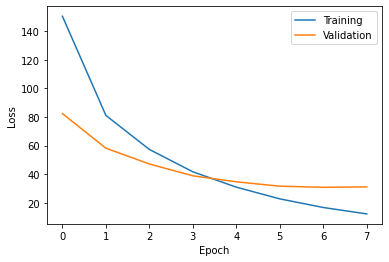

In [24]:
import matplotlib.pyplot as plt

plt.plot(training_losses, label = 'Training')
plt.plot(validation_losses, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
model.load_state_dict(torch.load('encoder_decoder_with_attention.pt'))
test_loss = evaluate(model, test_data_iterator, criterion)
print(f"Test Loss (exponent to analyse better): {np.exp(test_loss):.3f}")

Test Loss (exponent to analyse better): 30.144


In [27]:
def translate(text):
  model.eval()
  with torch.no_grad():
    tokens = english_tokenizer(text)
    tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
    src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_tensor = src_tensor.reshape(-1,1)

    output = model(src_tensor, src_tensor)
    output_dim = output.shape[-1]
    output = output.view(-1, output_dim)
    indices = torch.argmax(output,dim=1).tolist()
    return [HINDI.vocab.itos[x] for x in indices]

print(translate("man speaking native language:"))

['हंगरी', 'पुरुष', 'अपनी', 'मातृभाषा', 'मातृभाषा', 'में', 'बोल']


In [ ]:
# for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):
#   print(eng_sentence, hin_sentence)

In [58]:
import csv

translated_sentences = open('Paper2.csv','w')
csvwriter = csv.writer(translated_sentences)
csvwriter.writerow(['Input','Predicted','Actual'])  

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

translated_sentences.close()



In [59]:
with open('Paper2.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} \t \t {row[1]} \t \t {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are Input, Predicted, Actual
	Maybe Doug's back there. 	 	 <unk> <unk> वापस वापस वापस . . 	 	 शायद डौग वापस वहाँ है..
	What's with all the cameras? 	 	 <unk> <unk> <unk> <unk> है ? 	 	 सभी कैमरों के साथ क्या है?.
	Will my journey stop? 	 	 <unk> <unk> पैसे <unk> जीता है 	 	 Will my journey stop?.
	- Oh, really great. 	 	 <unk> , , , , , 	 	 - ओह, सच में बहुत अच्छा।.
	Your dad used to say: 	 	 <unk> <unk> के लिए है 	 	 तुम्हारे पिताजी कहा करते थे:.
	If we go to war... 	 	 <unk> बच्चे के के . . . 	 	 लड़ाई छेड़ी....
	Why is not it glowing? 	 	 <unk> <unk> <unk> नहीं है ? 	 	 यह चमक क्यों नहीं है?.
	That's a good idea, honey. 	 	 <unk> एक एक , , है . 	 	 यह एक अच्छा विचार है, शहद है।.
	- What's your name? 	 	 <unk> नाम नाम नाम है ? 	 	 -तुम्हारा नाम क्या है?.
	It was all me, James. 	 	 <unk> <unk> मुझे , , , . 	 	 सबकी मौत के पीछे का कारण मैं ही था, जेम्स।.
	You get that tank.. 	 	 <unk> <unk> <unk> <unk> . . 	 	 वो टैंक लो.
	And that was that. 	 	 <unk> कि कि कि था . 	 	 और 

In [56]:
# import csv

# translated_sentences = open('Paper2.csv','w')
# csvwriter = csv.writer(translated_sentences)
# csvwriter.writerow(['Input','Predicted','Actual'])  

import nltk

bleu_i = []
bleu_o = []

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  # csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  bleu_i.append(hin_sentence.strip())
  bleu_o.append(hindi_predicted.strip())

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

# translated_sentences.close()

BLEU_scores = []

for i in range(len(bleu_i)):
  BLEU_scores.append(nltk.translate.bleu_score.sentence_bleu(bleu_i[i], bleu_o[i], smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method7))
  
print("Average BLEU Score:", np.mean(BLEU_scores))



Average BLEU Score: 0.3390682622909464
